*Stanislav Borysov [stabo@dtu.dk], DTU Management*
# Advanced Business Analytics

## Uncertainty in Regression

**WARNING: This notebook contains more advanced Python code than the previous ones. You are not supposed to fully understand all the code but rather follow the main steps and understand general principles. There are might be a few other tools and packages available to solve these problems with much less programming.**

### 1. Boston Housing Dataset

This dataset contains information collected by the U.S Census Service concerning housing in the area of Boston Mass. It was obtained from the StatLib archive (http://lib.stat.cmu.edu/datasets/boston) and has been used extensively throughout the literature to benchmark algorithms. The dataset is small in size with only 506 cases. The data was originally published by *Harrison, D. and Rubinfeld, D.L. Hedonic prices and the demand for clean air, J. Environ. Economics & Management, vol.5, 81-102, 1978.*

The following describes the dataset columns:

- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centers
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per \$10,000
- PTRATIO - pupil-teacher ratio by town
- B - 1000(Bk - 0.63)^2 where Bk is the proportion of people of African American descent by town
- LSTAT - % lower status of the population
- MEDV - Median value of owner-occupied homes in $1000's

The MEDV variable is the target variable.

*Comment about the B variable: An analyst should be extremely careful about the well-known "correlation vs causation" problem as well as more recent research related to fairness and biases in machine learning and datasets. You can read about it in many places, for example,*

- https://www.technologyreview.com/s/612775/algorithms-criminal-justice-ai/
- https://www.iperceptions.com/blog/causation-vs-correlation
- https://towardsdatascience.com/is-your-machine-learning-model-biased-94f9ee176b67
- https://en.wikipedia.org/wiki/Correlation_does_not_imply_causation

As usual, let us start our analysis by taking look at the data

In [1]:
import pandas as pd
import numpy as np

In [2]:
column_names = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 
    'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'
]
data = pd.read_csv('data/housing.csv', header=None, delimiter=r"\s+", names=column_names)
data.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [3]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In our analysis, we will use only a subset of variables as features to predict the house prices

In [4]:
X_columns = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']
y_column = 'MEDV'
X = data.loc[:, X_columns].values
y = data[y_column].values

As common in statistical and machine learning analysis, we will scale the features to the same range. Particularly, we will use `sklearn.preprocessing.MinMaxScaler` to have all the feature values in the [0, 1] range.

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

To plot our target variable against the features, we will use the `seaborn` package. It is a very powerful plotting library which has advanced functionality built on top of  `matplotlib`. For instance, on top of the regular scatter plot, it can plot linear regression fitted for each feature separately.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/Users/borysov/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


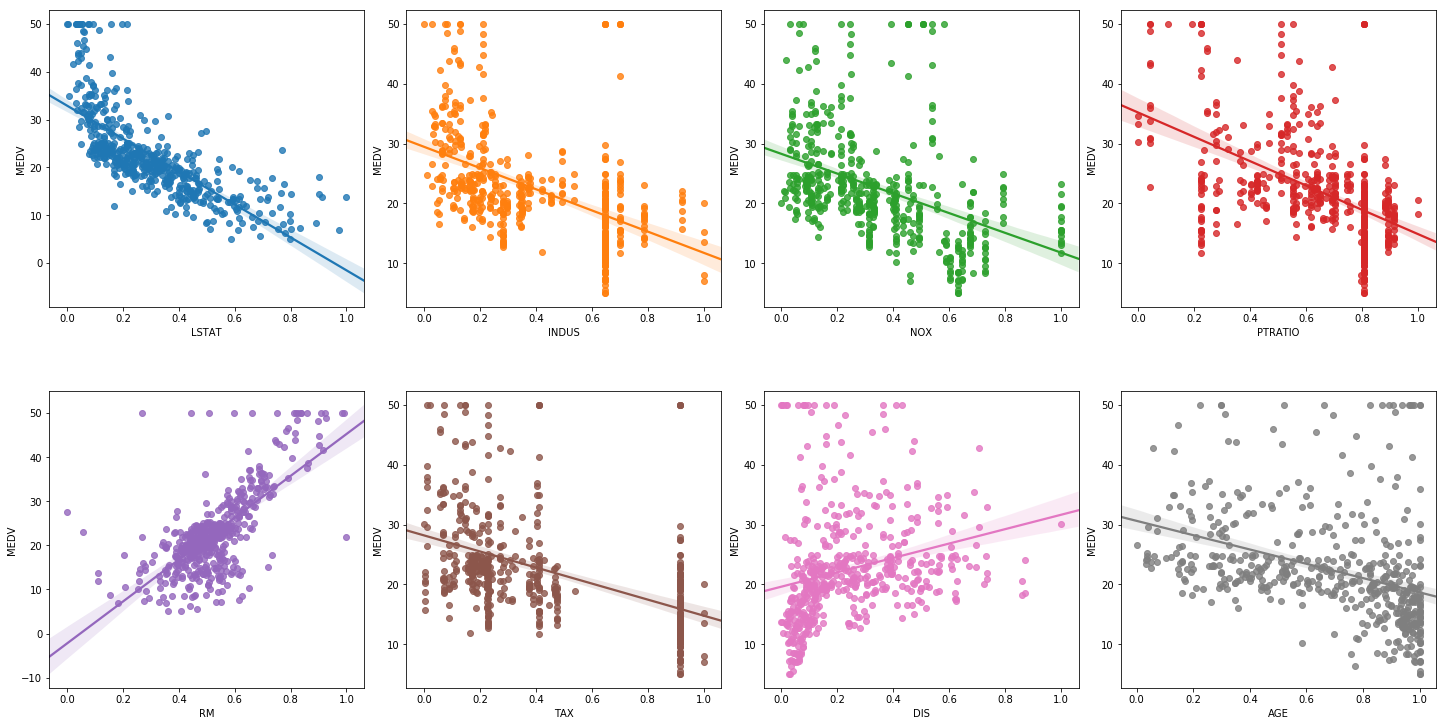

In [8]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
axs = axs.flatten()
for i, col in enumerate(X_columns):
    sns.regplot(y=y, x=X[:, i], ax=axs[i]) # it also does regression!
    axs[i].set_xlabel(col)
    axs[i].set_ylabel(y_column)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Note the shaded area around each regression line. This is a confidence interval for the model mean (i.e., regression coefficients, $\beta$) calculated using statistical bootstrapping. The concept of a confidence interval is different from the concept of a prediction interval (uncertainty), which is related to the variance of the data distribution itself (e.g., $\sigma$ in Gaussian):

> **Confidence intervals** tell you about how well you have determined the mean. Assume that the data really are randomly sampled from a Gaussian distribution. If you do this many times and calculate a confidence interval of the mean from each sample, you'd expect about 95 % of those intervals to include the true value of the population mean. The key point is that the confidence interval tells you about the likely location of the true population parameter.

> **Prediction intervals** tell you where you can expect to see the next data point sampled. Assume that the data really are randomly sampled from a Gaussian distribution. Collect a sample of data and calculate a prediction interval. Then sample one more value from the population. If you do this many times, you'd expect that next value to lie within that prediction interval in 95% of the samples.The key point is that the prediction interval tells you about the distribution of values, not the uncertainty in determining the population mean. Prediction intervals must account for both the uncertainty in knowing the value of the population mean, plus data scatter. So a prediction interval is always wider than a confidence interval.

You can read more about the difference between the two concepts [here](https://www.graphpad.com/support/faq/the-distinction-between-confidence-intervals-prediction-intervals-and-tolerance-intervals/).

### 2. Preliminary regression analysis

#### 2.1. Cross-validation

To compare our models, we will use regular 10-fold cross-validation (CV)

In [9]:
from sklearn.model_selection import KFold

In [10]:
kf = KFold(n_splits=10)

#### 2.2. Simple baseline

As a simple baseline, we will use the mean prediction, which is implemented in `sklearn.dummy.DummyRegressor`. To calculate CV Mean Squared Errors (MSE) of this baseline, we can use `sklearn.model_selection.cross_val_predict` to get CV predictions and then use `sklearn.metrics.mean_squared_error`.

In [11]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

In [12]:
model = DummyRegressor()
y_pred = cross_val_predict(model, X, y, cv=kf)
error = mean_squared_error(y, y_pred)
print("MSE: {:0.2f}".format(error))

MSE: 92.14


This is going to be our baseline score for the mean price prediction. We can also visualize these predictions versus the true data on a "45-degree" plot.

*Sidenote: Plotting routine is usually not particularly challenging but it can be very time-consuming, especially, if you want to make a "perfect" plot. In this notebook, we will use predefined functions for plotting. You are encouraged to take a look at them and re-use whenever is needed.*

In [13]:
def plot_45(y_true, y_pred):
    # find the limits of the data and add some margins
    y_min, y_max = min(min(y_pred), min(y_true)), max(max(y_pred), max(y_true))
    eps = 5
    y_lim_min = y_min - eps
    y_lim_max = y_max + eps
    # pyplot plotting
    fig = plt.figure(figsize=(5, 5))
    plt.plot([y_lim_min, y_lim_max], [y_lim_min, y_lim_max], ls="--", c="grey")
    plt.scatter(y_pred, y_true, s=20, alpha=0.3)
    plt.xlabel("{} Predicted".format(y_column))
    plt.ylabel("{} True".format(y_column))
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
    plt.ylim(y_lim_min, y_lim_max)
    plt.xlim(y_lim_min, y_lim_max)
    plt.show()

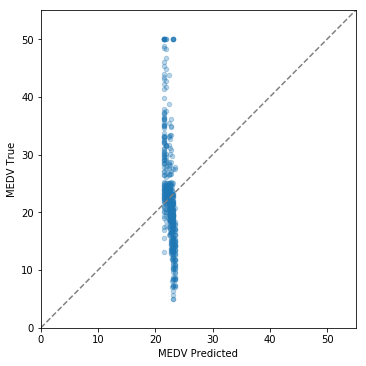

In [14]:
plot_45(y, y_pred)

As you can see, it is not a particularly impressive model...

#### 2.3. OLS linear regression

As another baseline, we will use Ordinary Least Squares (OLS) linear regression implemented in `sklearn.linear_model.LinearRegression`. This is a very common model used for mean prediction which assumes a constant gaussian error ($\sigma=\mathrm{const}$). Repeat all the steps as for the dummy model: calculate CV predictions, their MSE and visualize them using the `plot_45()` function.

In [15]:
from sklearn.linear_model import LinearRegression

/Users/borysov/py3/lib/python3.5/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


MSE: 34.77


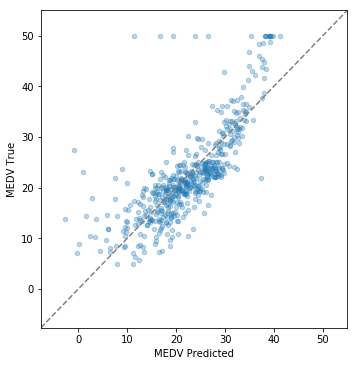

In [16]:
model = LinearRegression()
y_pred = cross_val_predict(model, X, y, cv=kf)
error = mean_squared_error(y, y_pred)
print("MSE: {:0.2f}".format(error))
plot_45(y, y_pred)

The CV MSE of 34.77 and the 45-degree plot look much better now.

### 3. Uncertanty prediction

The main topic of this lecture is the prediction uncertainty for regression models. It involves modeling of the whole data distribution and not just the mean as in the OLS case. For example, if we assume the data distribution in the Gaussian form, then we need to model two parameters: $\mu$ and $\sigma$. Using the log-likelihood (LL) method, we will try to learn both models for $\mu(X)$ and $\sigma(X)$ simultaneously. In a nutshell, the method can be described as follows:

1. Choose a distribution you would like to fit, e.g. Gaussian, with parameters $\lambda_1$, $\lambda_2$, $\dots$.
2. Specify models for the parameters in some parametric (or non-parametric) form, i.e., $\hat\lambda_1(X)$, $\hat\lambda_2(X)$, $\dots$.
3. Define the LL for the assumed distribution, which depends on the observed data and the models.
4. Find the models' parameters which maximize the LL (or, equivalently, minimize the negative LL) using some optimization algorithm.

#### 3.1. Optimizing log-likelihood using linear regression

In this task, we will use a model that is built to be compatible with the `sklearn` model specification. In this case, it can be used in other `sklearn` functions, such as `cross_val_score` and `cross_val_predict`. Although it might look a bit scary, try to read the code below and understand the overall logic. Of course, you are not supposed to implement your sklearn models, however, if you are interested, you can read about Python classes [here](https://www.w3schools.com/python/python_classes.asp) and sklearn estimators [here](http://danielhnyk.cz/creating-your-own-estimator-scikit-learn/). An alternative implementation in plain Python can be found in the Appendix, at the very end of this notebook also just for your reference.

*Important note: In the model below, we tried only power transformations of the features. However, other transformations such as `exp` or `log` should work much better.*

In [17]:
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import minimize


# new sklearn estimators should inherit from the base class 'sklearn.base.BaseEstimator'
class ModelPoly(BaseEstimator):
    
    # class constructor
    def __init__(self, mu_degree=None, sigma_degree=None):
        # polynomial degree of the model for mu
        self.mu_degree = mu_degree
        # polynomial degree of the model for sigma
        self.sigma_degree = sigma_degree
    
    # negative log-likelihood to optimize
    # since we use scipy.optimize, it should have only one input variable --
    # a numpy array with all the parameters of our models
    def loss_(self, params):
        # manually update the parameters passed to the function by the optimizer
        self.model_mu.named_steps.lr.coef_ = params[:self.model_mu_params_n]
        self.model_sigma.named_steps.lr.coef_ = params[self.model_mu_params_n:]
        # calculate new predictions
        mu = self.model_mu.predict(self.X)
        sigma = self.model_sigma.predict(self.X)
        # calculate negative log-likelihood
        nll = np.log(sigma**2) + (self.y - mu)**2 / sigma**2
        nll = np.sum(nll) / 2.0 # sum over samples
        return nll
    
    # fitting the model to the data
    def fit(self, X, y):
        # just to check that we have everything needed
        if self.mu_degree is None or self.sigma_degree is None:
            raise Exception("mu_degree is None or sigma_degree is None")
        # reference to the data
        self.X, self.y = X, y
        # specify linear models with power transformations
        self.model_mu = Pipeline([
            ("pf", PolynomialFeatures(degree=self.mu_degree, include_bias=True)),
            ("lr", LinearRegression(fit_intercept=False))
        ])
        self.model_sigma = Pipeline([
            ("pf", PolynomialFeatures(degree=self.sigma_degree, include_bias=True)),
            ("lr", LinearRegression(fit_intercept=False))
        ])
        # the two lines below virtually do nothing
        self.model_mu.named_steps.pf.fit(X)
        self.model_sigma.named_steps.pf.fit(X)
        # although we do not fit and use intercept as it is included in zero-power ('include_bias=True')
        # of the polynomial, sklearn does want to assign some value to the intercept anyway,
        # it gives an error otherwise
        self.model_mu.named_steps.lr.intercept_ = 0
        self.model_sigma.named_steps.lr.intercept_ = 0
        # number of parameters for each model
        self.model_mu_params_n = self.model_mu.named_steps.pf.n_output_features_
        self.model_sigma_params_n = self.model_sigma.named_steps.pf.n_output_features_
        # try to understand the following line yourself
        params = np.full((self.model_mu_params_n + self.model_sigma_params_n,), 0.1)
        # run optimization using Powell's method, which does not require gradients or Hessian matrix
        res = minimize(self.loss_, params, method='Powell', options={
            'xtol': 1e-8, 
            'disp': True
        })
        # save the results (the optimal parameters)
        self.model_mu.named_steps.lr.coef_ = res.x[:self.model_mu_params_n]
        self.model_sigma.named_steps.lr.coef_ = res.x[self.model_mu_params_n:]
        # we do not need the references to the data anymore
        self.X, self.y = None, None
    
    # prediction of mu
    def predict_mu(self, X):
        return self.model_mu.predict(X)
    
    # prediction of sigma
    def predict_sigma(self, X):
        return self.model_sigma.predict(X)
    
    # by default, our model predicts just mu
    def predict(self, X):
        return self.predict_mu(X)
    
    # calculate LL for the data
    def score(self, X, y):
        # reference to the data
        self.X, self.y = X, y
        params = np.concatenate((self.model_mu.named_steps.lr.coef_, 
                                 self.model_sigma.named_steps.lr.coef_), axis=None)
        loss = self.loss_(params)
        # we do not need the references to the data anymore
        self.X, self.y = None, None
        return -loss

Having implemented a sklearn-compatible estimator, we can use it as any other sklearn model. First, we will try the linear mean $\mu(X)=\beta_0+\beta_1x_1+\alpha_2x_2+\dots$ and constant variance $\sigma(X)=\alpha_0$, which should produce the equivalent solution to the OLS LR above. The linear mean model with constant variance can be defined as 

>```model = ModelPoly(1, 0)```

Repeat all the steps as for the dummy and LR models: calculate CV predictions, their MSE and visualize them using the `plot_45()` function.

Optimization terminated successfully.
         Current function value: 973.273592
         Iterations: 17
         Function evaluations: 2402
Optimization terminated successfully.
         Current function value: 969.988331
         Iterations: 20
         Function evaluations: 2764
Optimization terminated successfully.
         Current function value: 970.498953
         Iterations: 15
         Function evaluations: 2064
Optimization terminated successfully.
         Current function value: 948.980519
         Iterations: 18
         Function evaluations: 2537
Optimization terminated successfully.
         Current function value: 958.638268
         Iterations: 19
         Function evaluations: 2654
Optimization terminated successfully.
         Current function value: 964.172671
         Iterations: 20
         Function evaluations: 2854
Optimization terminated successfully.
         Current function value: 971.651453
         Iterations: 18
         Function evaluations: 2537
Optimi

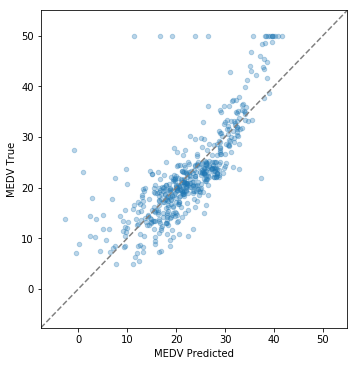

In [18]:
model = ModelPoly(1, 0)
y_pred = cross_val_predict(model, X, y, cv=kf)
error = mean_squared_error(y, y_pred)
print("MSE: {:0.2f}".format(error))
plot_45(y, y_pred)

The CV MSE should be almost the same as for the LR. They might be slightly different because of using the optimization procedure instead of the analytical OLS solution.

Another important idea is that the model's LL can serve as metrics to compare different probabilistic models and not just their mean predictions. We can calculate it using `sklearn.model_selection.cross_val_score`. If a scoring function is not specified in `cross_val_score`, then the `model.score(X, y)` function will be used for this. In the `PolyModel` class, the `score` function is implemented to calculate the LL of the data.

In [19]:
from sklearn.model_selection import cross_val_score

In [20]:
scores = cross_val_score(model, X, y, cv=kf)
print("LL: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std()))
print(-scores)

Optimization terminated successfully.
         Current function value: 973.273592
         Iterations: 17
         Function evaluations: 2402
Optimization terminated successfully.
         Current function value: 969.988331
         Iterations: 20
         Function evaluations: 2764
Optimization terminated successfully.
         Current function value: 970.498953
         Iterations: 15
         Function evaluations: 2064
Optimization terminated successfully.
         Current function value: 948.980519
         Iterations: 18
         Function evaluations: 2537
Optimization terminated successfully.
         Current function value: 958.638268
         Iterations: 19
         Function evaluations: 2654
Optimization terminated successfully.
         Current function value: 964.172671
         Iterations: 20
         Function evaluations: 2854
Optimization terminated successfully.
         Current function value: 971.651453
         Iterations: 18
         Function evaluations: 2537
Optimi

Another important challenge is how to visualize prediction intervals when more than one feature is used. I did not find an elegant answer to this, so you can think about it and let the other people know if you have any ideas. The function below plots predictions and intervals for each feature separately while setting the remaining features to their mean value. The problem is that, when the actual values are used, predictions become noisy as the predictions for nearby points do not coincide because of the dependence on the rest of the features. You can set `use_mean=False` to see the problem. Maybe, moving window average can help? You can try to solve this problem if you are interested...

In [21]:
def plot_all(model, use_mean=True, keras_model=False):
    # calculate mean values
    X_means = X.mean(axis=0)
    # set up the plot
    fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
    index = 0
    axs = axs.flatten()
    # iterate through the features
    for i, col in enumerate(X_columns):
        if use_mean:
            # set all the features to their means except for the feature to be plotted
            X_pred = np.zeros(X.shape)
            X_pred[:] = X_means
            X_pred[:, i] = X[:, i]
        else:
            X_pred = X.copy()
        # this function will be used to plot keras NN models later
        if keras_model:
            y_log_s_pred = model.predict(X_pred)
            y_pred, log_s_pred = y_log_s_pred[:, 0], y_log_s_pred[:, 1]
            # in NN, we predict log(sigma) instead of sigma
            s_pred = np.exp(log_s_pred)
        else:
            y_pred = model.predict_mu(X_pred)
            s_pred = model.predict_sigma(X_pred)
        X_plot = X_pred[:, i]
        # sort values for the correct line plotting
        X_plot, y_pred, s_pred = zip(*sorted(zip(X_plot.tolist(), y_pred.tolist(), s_pred.tolist())))
        X_plot, y_pred, s_pred = np.array(X_plot), np.array(y_pred), np.array(s_pred)
        # plot samples
        axs[i].scatter(X[:, i], y, s=20, alpha=0.3)
        # plot mean
        axs[i].plot(X_plot, y_pred, '-', color='gray', label="Model $\mu\pm1.96\sigma$")
        # plot 95% prediction interval
        axs[i].plot(X_plot, y_pred - 1.96 * s_pred, '--', color='gray', alpha=0.5)
        axs[i].plot(X_plot, y_pred + 1.96 * s_pred, '--', color='gray', alpha=0.5)
        axs[i].fill_between(X_plot, y_pred - 1.96 * s_pred, y_pred + 1.96 * s_pred,
                         color='gray', alpha=0.2, interpolate=True)
        axs[i].legend(loc="best")
        axs[i].set_xlabel(col)
        axs[i].set_ylabel(y_column)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
    plt.show()

Optimization terminated successfully.
         Current function value: 1065.809424
         Iterations: 18
         Function evaluations: 2607


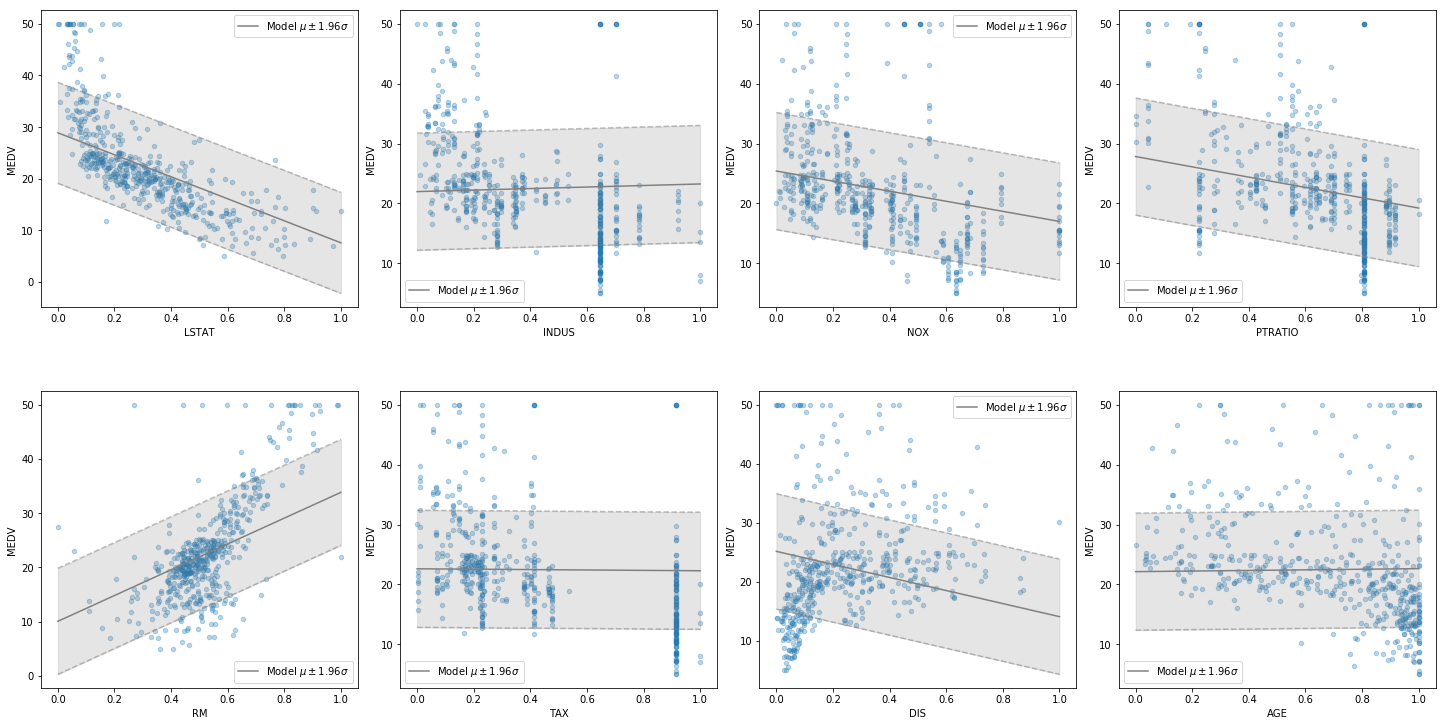

In [22]:
# we can fit the model to all the samples for the visualization
model.fit(X, y)
plot_all(model)

Let us now try a linear model for the standard deviation, $\sigma(X)=\alpha_0+\alpha_1x_1+\alpha_2x_2+\dots$. For mean, we will still use the same linear model as before, $\mu(X)=\beta_0+\beta_1x_1+\alpha_2x_2+\dots$. We can specify this model using

>```model = ModelPoly(1, 1)```

Repeat all the steps as for the previous model: calculate CV predictions, calculate their MSE and LL, plot them using `plot_45()`, fit the model to the whole dataset and visualize the predictions using `plot_all()`.

Optimization terminated successfully.
         Current function value: 895.589865
         Iterations: 21
         Function evaluations: 7384
Optimization terminated successfully.
         Current function value: 899.847260
         Iterations: 14
         Function evaluations: 4705
Optimization terminated successfully.
         Current function value: 937.161415
         Iterations: 10
         Function evaluations: 3567
Optimization terminated successfully.
         Current function value: 876.368679
         Iterations: 13
         Function evaluations: 4208
Optimization terminated successfully.
         Current function value: 868.482352
         Iterations: 22
         Function evaluations: 8248
Optimization terminated successfully.
         Current function value: 883.779120
         Iterations: 13
         Function evaluations: 4209
Optimization terminated successfully.
         Current function value: 893.256603
         Iterations: 18
         Function evaluations: 6504
Optimi

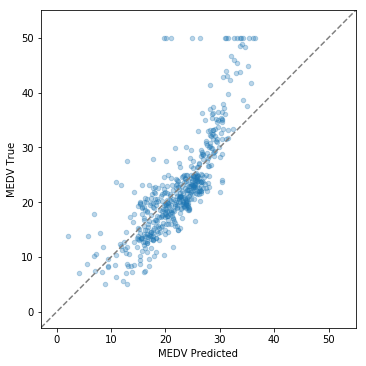

Optimization terminated successfully.
         Current function value: 974.196273
         Iterations: 22
         Function evaluations: 8104


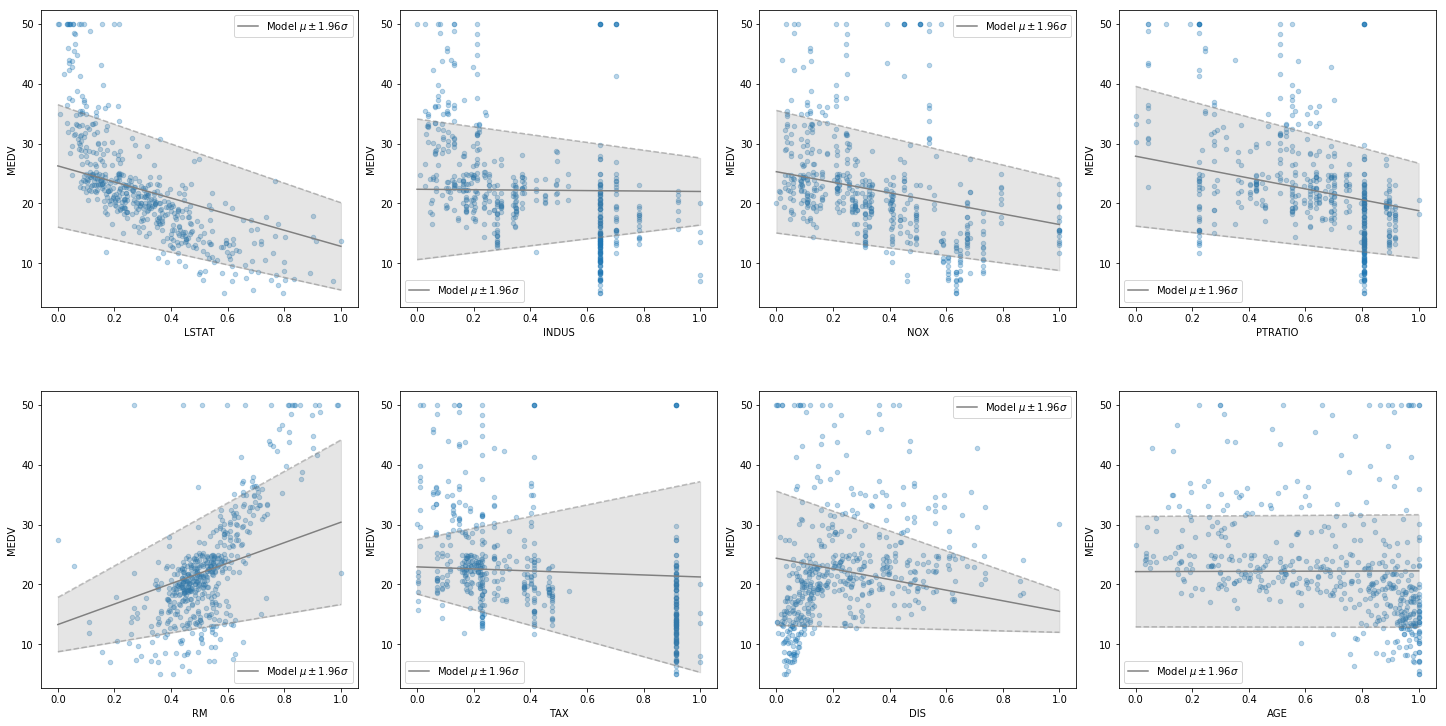

In [23]:
model = ModelPoly(1, 1)
y_pred = cross_val_predict(model, X, y, cv=kf)
error = mean_squared_error(y, y_pred)
print("MSE: {:0.2f}".format(error))
plot_45(y, y_pred)
model.fit(X, y)
plot_all(model)

In [24]:
scores = cross_val_score(model, X, y, cv=kf)
print("LL: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std()))
print(-scores)

Optimization terminated successfully.
         Current function value: 895.589865
         Iterations: 21
         Function evaluations: 7384
Optimization terminated successfully.
         Current function value: 899.847260
         Iterations: 14
         Function evaluations: 4705
Optimization terminated successfully.
         Current function value: 937.161415
         Iterations: 10
         Function evaluations: 3567
Optimization terminated successfully.
         Current function value: 876.368679
         Iterations: 13
         Function evaluations: 4208
Optimization terminated successfully.
         Current function value: 868.482352
         Iterations: 22
         Function evaluations: 8248
Optimization terminated successfully.
         Current function value: 883.779120
         Iterations: 13
         Function evaluations: 4209
Optimization terminated successfully.
         Current function value: 893.256603
         Iterations: 18
         Function evaluations: 6504
Optimi

The MSE for the $\mu$ has been slightly improved. However, it seems that there is a strange outliner in one of the CV folds for the LL. I could not identify a possible cause myself but you can help me if you want ;)

Try more complex models and/or include other data transformations. Also, since the LL for more complex models becomes non-convex, the optimization results depend on the starting point (and the optimization algorithm itself). So, try also different initial values for the parameters and check if you can further improve the results. You need to find and modify the initialization of the parameters is in the `ModelPoly` class definition above.

In [25]:
# ...

#### 3.2. Optimizing log-likelihood using neural networks

We can repeat the same task using highly flexible models specified with a neural network which outputs parameters of our distribution. Here, we will use [keras](https://keras.io/) again.

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Concatenate, Input
from tensorflow.keras import backend as K # TensorFlow functions
from tensorflow.keras.optimizers import RMSprop

*The code in the cell bellow can be used to plot learning progress. It is completely irrelevant for the class but it might be useful in general. To enable it, you can specify `PlotLosses` as a callback when fitting the model (you will see an example below).*

In [27]:
# updatable plot
# a minimal example (sort of)
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        #m1, m2 = 'train', 'validation'
        m1, m2 = 'loss', 'val_loss'
        #m1, m2 = 'acc', 'val_acc'
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get(m1))
        self.val_losses.append(logs.get(m2))
        self.i += 1
        
        clear_output(wait=True)
        
        fig = plt.figure(figsize=(6, 4), dpi=150)
        #plt.plot(self.x, np.log(self.losses), label=m1)
        #plt.plot(self.x, np.log(self.val_losses), label=m2)
        plt.plot(self.x, self.losses, label='train')
        plt.plot(self.x, self.val_losses, label='validation', ls='--')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        #ax1.axhline(line, ls=linestyles[i], color=color)
        plt.legend()
        plt.show();
        
plot_learning = PlotLosses()

Below, we specify a neural network model. It takes the features $X$ and outputs the two values: $\mu$ and $\log\sigma$. This transformation maps the output values from $[0, +\inf]$ to $[-\inf, +\inf]$ so a linear neuron can be used as an output. Alternatively, you can try exponential or softplus transformations.

In [28]:
def keras_nll_model(input_size): 
    inputs = Input(shape=(input_size,))    
    
    # A few examples of different NN architectures:
    
    # 1. The simplest one (= linear mean and log(sigma))
    #output = Dense(2)(inputs)
    
    # 2. 1 shared hidden layer
    #h = Dense(50, activation='tanh')(inputs)
    #output = Dense(2)(h)
    
    # 3. 2 separate hidden layers
    hm = Dense(50, activation='tanh')(inputs)
    hs = Dense(50, activation='tanh')(inputs)
    m = Dense(1)(hm)
    s = Dense(1)(hs)
    output = Concatenate()([m, s])
    
    # 4. 1 shared + 2 separate hidden layers
    #h = Dense(100, activation='tanh')(inputs)
    #hm = Dense(10, activation='tanh')(h)
    #hs = Dense(10, activation='tanh')(h)
    #m = Dense(1)(hm)
    #s = Dense(1)(hs)
    #output = Concatenate()([m, s])
    
    # 5. Your architecture
    # ...
    
    model = Model(inputs=inputs, outputs=output)   
    optimiser = RMSprop(lr=0.01, rho=0.9)
    # you can try different parameters of the optimiser as well
    # ...
    model.compile(optimizer=optimiser, loss=keras_nll_loss, metrics=['mse'])
    return model

The negative LL loss to optimize is specified in the following cell. Here, we use TensorFlow functions implemented in `K` (`from tensorflow.keras import backend as K`), which are similar to the numpy functions but designed to work with TensorFlow variables.

In [29]:
def keras_nll_loss(y_true, y_pred):
    mean_true, log_s_true = y_true[:, 0], None
    mean_pred, log_s_pred = y_pred[:, 0], y_pred[:, 1]
    # ensure the correct data type
    mean_true = K.cast(mean_true, tf.float32)
    mean_pred = K.cast(mean_pred, tf.float32)
    log_s_pred = K.cast(log_s_pred, tf.float32)
    # calculate loss
    nll = log_s_pred + K.square(mean_true - mean_pred) / K.exp(2. * log_s_pred) / 2.    
    return K.sum(nll, axis=-1)

Unfortunately, `sklearn.model_selection.cross_val_score` does not work for keras models, so we need to implement the CV procedure ourselves. Note that the number of epochs and batch size are hyper-parameters as well (yes, NNs have a lot of them...).

In [30]:
def cross_val_predict_keras(model, X, y, cv, batch_size=32, epochs=100):
    y_pred = []
    for fold_i, (train_index, test_index) in enumerate(kf.split(X)):
        print("Calculating CV fold =", fold_i)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        #
        model.fit(X_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=0,
                  #callbacks=[plot_learning] # uncomment this line if you want to plot learning progress
                 )
        y_s_pred = model.predict(X_test)
        y_pred += y_s_pred[:, 0].tolist()
    return np.array(y_pred)

In [31]:
def cross_val_score_keras(model, X, y, cv, scoring, batch_size=32, epochs=100):
    scores = []
    for fold_i, (train_index, test_index) in enumerate(kf.split(X)):
        print("Calculating CV fold =", fold_i)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        #
        model.fit(X_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=0,
                  #callbacks=[plot_learning] # uncomment this line if you want to plot learning progress
                 )
        y_s_pred = model.predict(X_test)
        y_pred = y_s_pred[:, 0]
        s_pred = np.exp(y_s_pred[:, 1])
        if scoring == mean_squared_error:
            scores.append(scoring(y_test, y_pred))
        else:
            scores.append(scoring(y_test, y_s_pred))
    return np.array(scores)

We also need to implement the LL scoring function

In [32]:
def LL_keras(y, y_s_pred):
    return K.eval(keras_nll_loss(y.reshape(-1, 1), y_s_pred))

OK, everything is ready to try a keras model

In [33]:
model = keras_nll_model(X.shape[1])
epochs = 100
batch_size = 32
y_pred = cross_val_predict_keras(model, X, y, cv=kf, epochs=epochs, batch_size=batch_size)
error = mean_squared_error(y, y_pred)
print("MSE: {:0.2f}".format(error))

Calculating CV fold = 0
Calculating CV fold = 1
Calculating CV fold = 2
Calculating CV fold = 3
Calculating CV fold = 4
Calculating CV fold = 5
Calculating CV fold = 6
Calculating CV fold = 7
Calculating CV fold = 8
Calculating CV fold = 9
MSE: 15.37


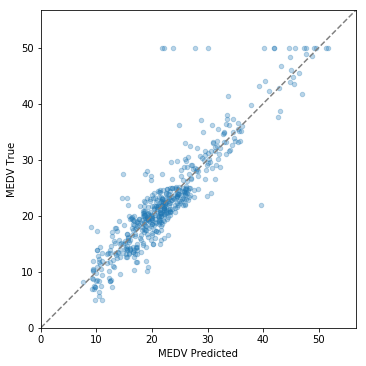

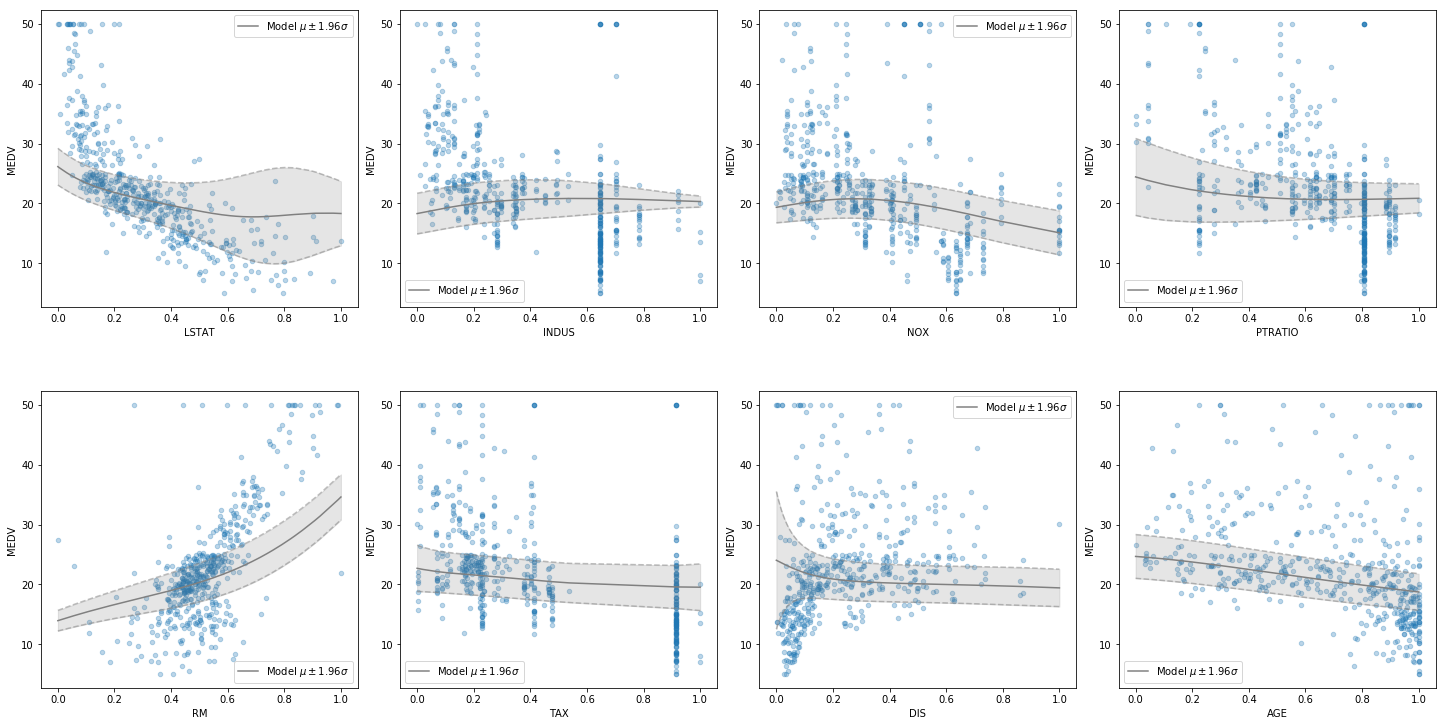

In [34]:
plot_45(y, y_pred)
model.fit(X, y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          #callbacks=[plot_learning]
         )
plot_all(model, keras_model=True)

In [35]:
scores = cross_val_score_keras(model, X, y, cv=kf, scoring=LL_keras, epochs=epochs, batch_size=batch_size)
print("LL: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
scores

Calculating CV fold = 0
Calculating CV fold = 1
Calculating CV fold = 2
Calculating CV fold = 3
Calculating CV fold = 4
Calculating CV fold = 5
Calculating CV fold = 6
Calculating CV fold = 7
Calculating CV fold = 8
Calculating CV fold = 9
LL: 66.52 (+/- 19.73)


array([80.915985, 44.987625, 42.1868  , 82.25076 , 73.70675 , 44.976833,
       47.655457, 99.09957 , 87.27193 , 62.102158], dtype=float32)

The results of the model without hidden layers should be similar to the `PolyModel(1, 1)`. The results of the model with 2 separate hidden layers show much better MSE but lower LL. Try different NN architectures (number of hidden layers, number of neurons in the hidden layers, activation function) as well as the optimization parameters (e.g., learning rate) to see if it can improve modeling results. Repeat all the steps as before: calculate CV predictions, calculate their MSE and LL, plot them using `plot_45()`, fit the model to the whole dataset and visualize the predictions using `plot_all()`.

In [36]:
# ... You can modify keras_nll_model() and re-run the code above ...

### 4. Quantile regression

Let us finally do quantile regression which is another way to approximate a distribution. Instead of learning the PDF, it learns the quantile function, which the inverse of the CDF. It requires specification of a quantile model $Q_\tau(X)$ in some parametric (or non-parametric) form and optimization of the corresponding tilted loss. 

*We will not do any CV below for the sake of brevity, but remember that it is still necessary.*

#### 4.1. Quantile regression using multiple linear models

In the first exercise, we will optimize the tilted loss without classes and sklearn. First, we need to define our models

In [37]:
# constant model, which outputs one value independently of X
def model_const_func(X, params):
    return np.full(X.shape[0], params[0])

# simple linear model without feature transformations
def model_lin_func(X, params):
    return np.dot(np.hstack((np.ones((X.shape[0], 1)), X)), params)

The tilted (a.k.a. "quantile") loss has the following form

In [38]:
def quantile_loss(X, y, q, model_y_func, params_y):
    # calculate model's predictions
    y_pred = model_y_func(X, params_y)
    # calculate loss
    loss = np.sum(np.maximum(q*(y-y_pred), (q-1)*(y-y_pred)))
    return loss

`functools.partial` allows to set a subset of the function parameters, so they do not need to be defined when it is called later (similar to setting default values for the parameters)

In [39]:
from functools import partial

As before, we will use the `scipy` optimiser

In [40]:
from scipy.optimize import minimize

In [41]:
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
# you can try the constant model if you want
#y_func_model = model_const_func
y_func_model = model_lin_func
#
quant_models = []
for q in quantiles:
    # minimize function should have only one parameter, that's why we need functools.partial
    loss = partial(quantile_loss, X, y, q, y_func_model)
    # set initial values for the parameters (a starting point)
    #params_y = np.full(1, 0.1) # for the constant model
    params_y = np.full(X.shape[1] + 1, 0.1) # for the linear model
    # optimize
    res = minimize(loss, params_y, method='Powell', options={
        'xtol': 1e-8, 
        'disp': True
    })
    quant_models.append(partial(y_func_model, params=res.x))

Optimization terminated successfully.
         Current function value: 98.262853
         Iterations: 19
         Function evaluations: 6581
Optimization terminated successfully.
         Current function value: 588.755715
         Iterations: 25
         Function evaluations: 7995
Optimization terminated successfully.
         Current function value: 859.664869
         Iterations: 22
         Function evaluations: 6927
Optimization terminated successfully.
         Current function value: 198.026953
         Iterations: 17
         Function evaluations: 5773


For plotting, we will use the function below. Here, we have the same challenges with multidimensional data visualization as before.

In [42]:
def plot_quantiles(model, quantiles, use_median=True, keras_model=False):
    # calculate median values
    X_means = np.median(X, axis=0)
    fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
    axs = axs.flatten()
    # iterate through the features
    for i, col in enumerate(X_columns):
        if use_median:
            # set all the features to their medians except for the feature to be plotted
            X_pred = np.zeros(X.shape)
            X_pred[:] = X_means
            X_pred[:, i] = X[:, i]
        else:
            X_pred = X.copy()
        axs[i].scatter(X[:, i], y, s=20, alpha=0.3)
        # this function will be used to plot keras NN models later
        if keras_model:
            q_pred = model.predict(X_pred)
            y_pred_all = q_pred.T
        else:
            y_pred_all = [q_func(X_pred) for q_func in model]
        for q, y_pred in zip(quantiles, y_pred_all):
            X_plot = X[:, i]
            X_plot, y_pred = zip(*sorted(zip(X_plot.tolist(), y_pred.tolist())))
            X_plot, y_pred = np.array(X_plot), np.array(y_pred)
            axs[i].plot(X_plot, y_pred, '-', label=str(q))
        axs[i].legend(loc="best")
        axs[i].set_xlabel(col)
        axs[i].set_ylabel(y_column)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
    plt.show()

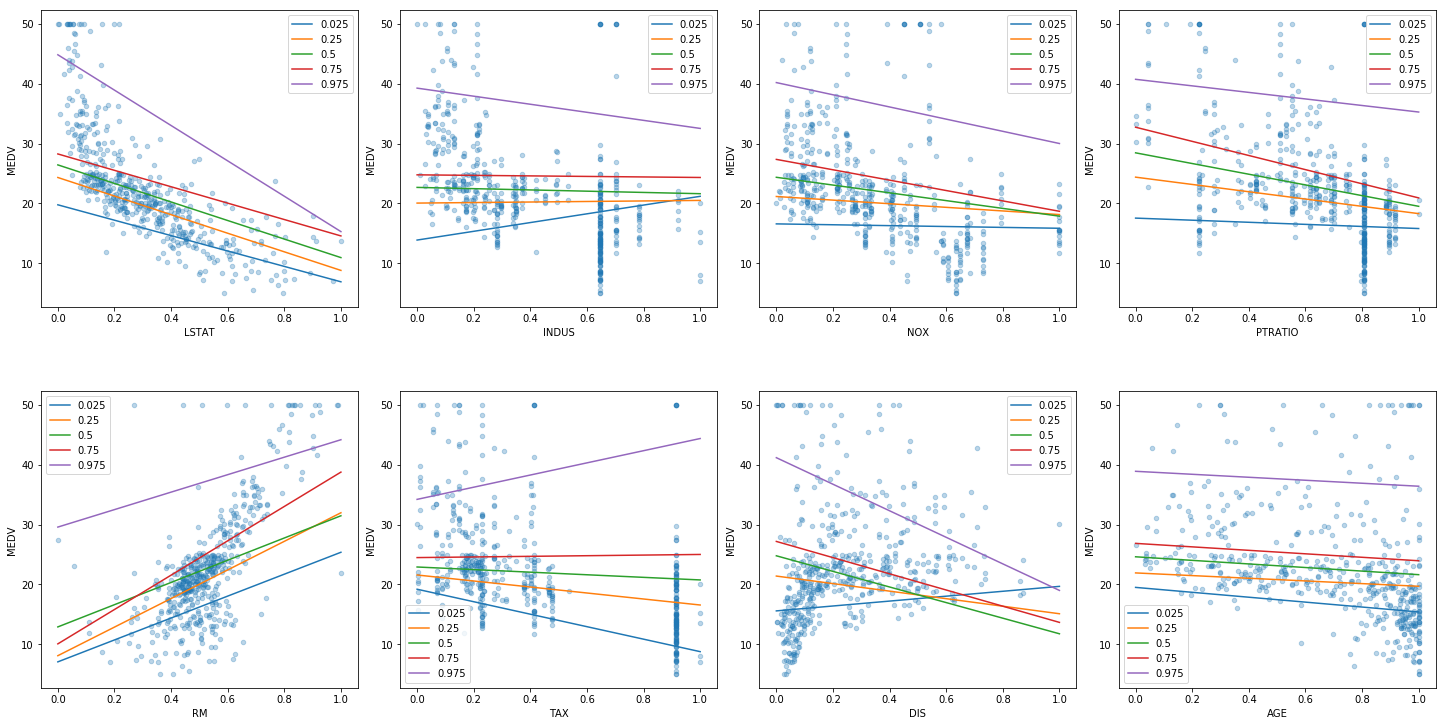

In [43]:
plot_quantiles(quant_models, quantiles, use_median=True)

Notice the crossings of the estimated quantile functions — they should be completely absent in theory.

#### 4.2. Multi-output quantile regression using neural networks

Again, we can use a NN for this task. We will calculate the following quantiles using a multi-output NN.

In [44]:
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

The tilted loss in keras can be defined as follows

In [45]:
def quantile_loss_nn(y_true, y_pred):
    loss = 0
    for q_i, q in enumerate(quantiles):
        e = y_true - y_pred[:, q_i:q_i+1]
        loss += K.mean(K.maximum(q*e, (q-1)*e))
    return loss# / len(quantiles) # normalization here does not affect the final result

Let us try a linear NN model first

In [46]:
def keras_linear_model(input_size, output_size, loss): 
    inputs = Input(shape=(input_size,))
    output = Dense(output_size)(inputs)
    model = Model(inputs=inputs, outputs=output)   
    optimiser = RMSprop(lr=0.01, rho=0.9)
    # you can try different parameters of the optimiser
    # ...
    model.compile(optimizer=optimiser, loss=loss, metrics=['mae'])
    return model

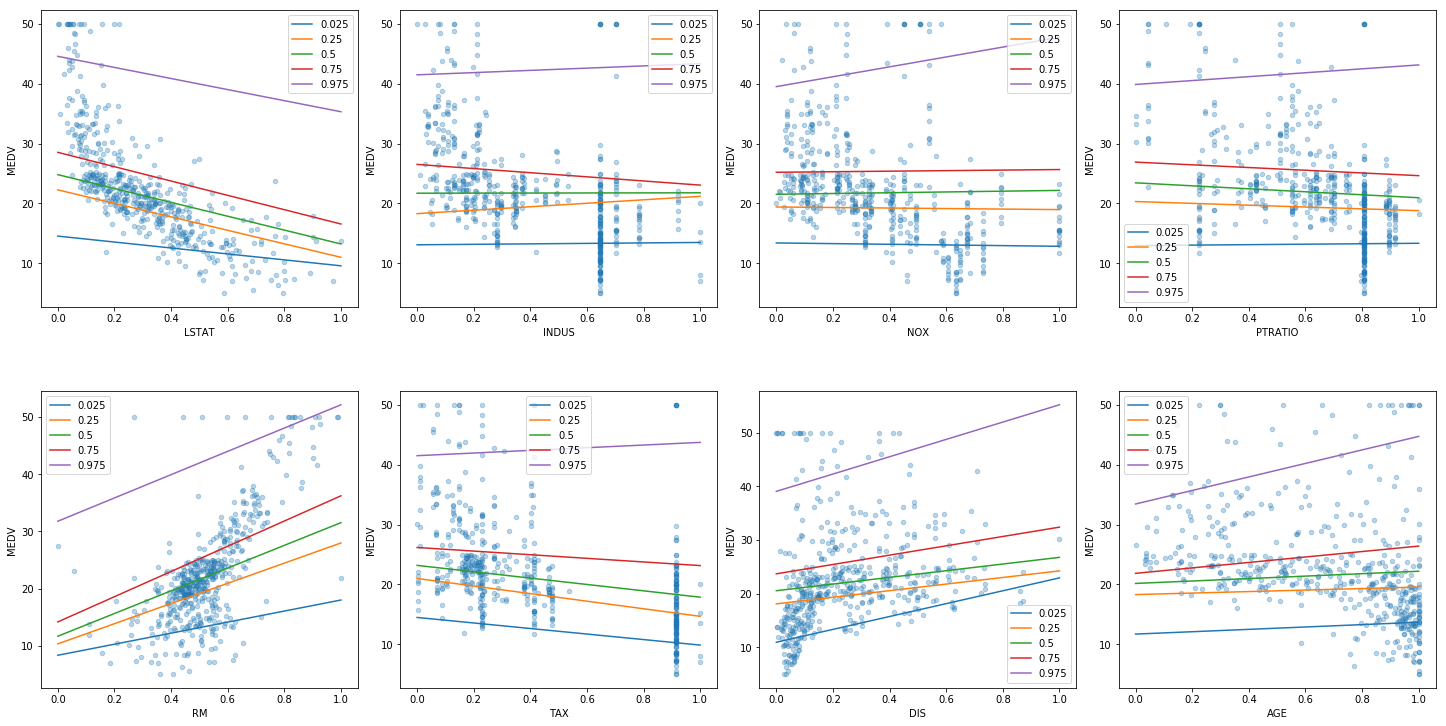

In [47]:
model = keras_linear_model(X.shape[1], len(quantiles), quantile_loss_nn)
epochs = 200
batch_size = 32
model.fit(X, y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          #callbacks=[plot_learning] # uncomment this line if you want to plot learning progress
         )
plot_quantiles(model, quantiles, use_median=True, keras_model=True)

It seems that we get much less (or even zero) crossings, which is a very good sign! Let us try a nonlinear model as well (do the same plot using `plot_quantiles()` as for the linear model).

In [48]:
def keras_nonlinear_model(input_size, output_size, loss): 
    inputs = Input(shape=(input_size,))
    h = Dense(100, activation='relu')(inputs)
    #h = Dense(50, activation='relu')(h)
    # try different architectures
    # ...
    output = Dense(output_size)(h)
    model = Model(inputs=inputs, outputs=output)
    optimiser = RMSprop(lr=0.01, rho=0.9)
    # you can try different parameters of the optimiser
    # ...
    model.compile(optimizer=optimiser, loss=loss, metrics=['mae'])
    return model

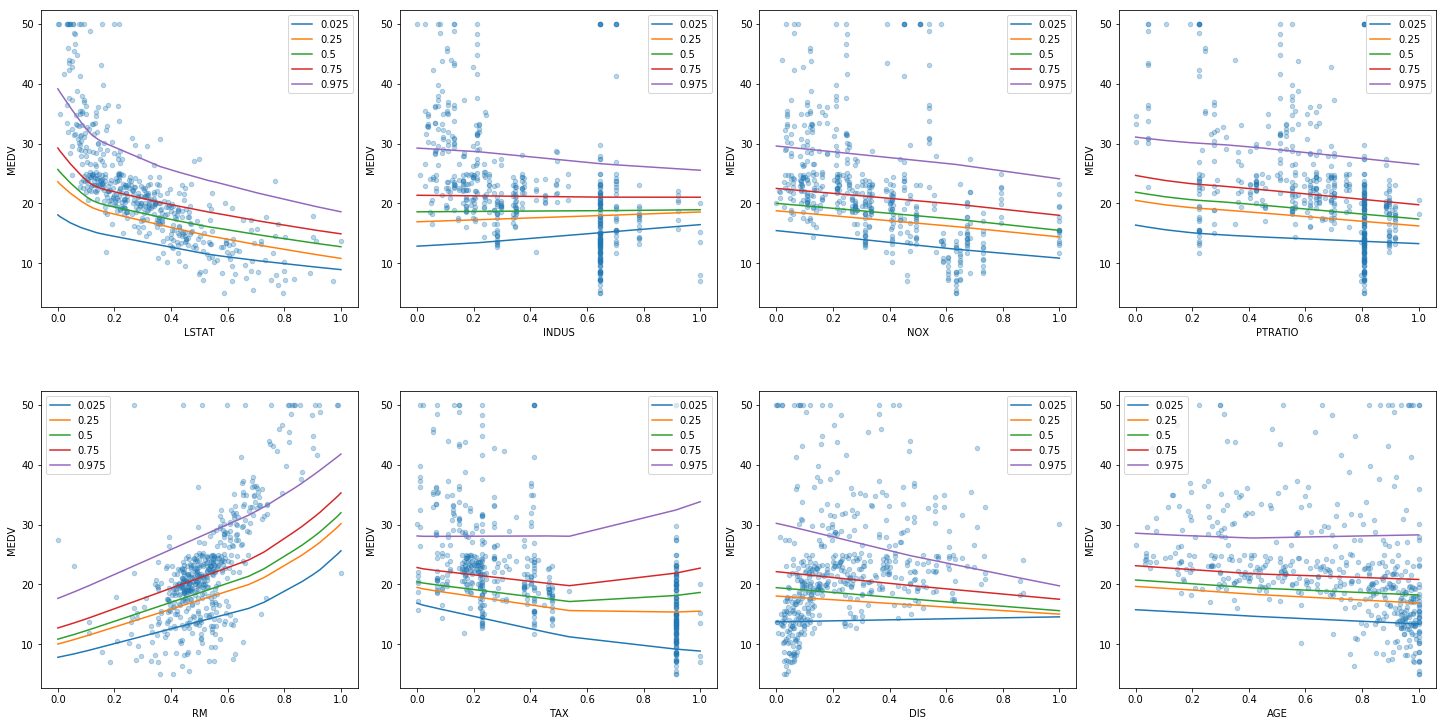

In [49]:
model = keras_nonlinear_model(X.shape[1], len(quantiles), quantile_loss_nn)
epochs = 100
batch_size = 32
model.fit(X, y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          #callbacks=[plot_learning]
         )
plot_quantiles(model, quantiles, use_median=True, keras_model=True)

Notice the complete absence of the crossings!

Finally, you can also use the median instead of the mean for the price prediction

Calculating CV fold = 0
Calculating CV fold = 1
Calculating CV fold = 2
Calculating CV fold = 3
Calculating CV fold = 4
Calculating CV fold = 5
Calculating CV fold = 6
Calculating CV fold = 7
Calculating CV fold = 8
Calculating CV fold = 9
MSE: 12.83


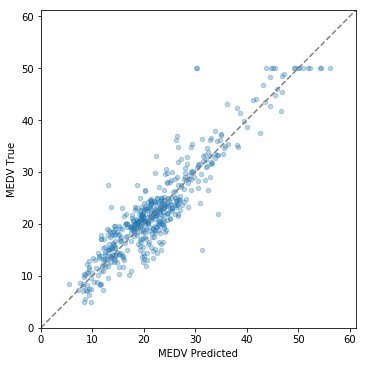

In [50]:
quantiles = [0.5, 0.5] # the second output will not be used
model = keras_nonlinear_model(X.shape[1], len(quantiles), quantile_loss_nn)
epochs = 100
batch_size = 32
y_pred = cross_val_predict_keras(model, X, y, cv=kf, batch_size=batch_size, epochs=epochs)
error = mean_squared_error(y, y_pred)
print("MSE: {:0.2f}".format(error))
plot_45(y, y_pred)

Not bad at all!

### Appendix: Alternative implementation of log-likelihood optimisation using linear regression without classes and sklearn

Optimization terminated successfully.
         Current function value: 976.997612
         Iterations: 21
         Function evaluations: 7449


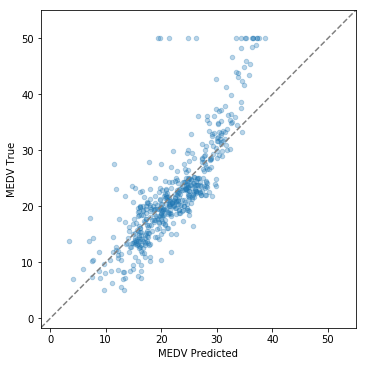

In [51]:
from scipy.optimize import minimize
from functools import partial


def model_const_func(X, params):
    return np.full(X.shape[0], params[0])

def model_lin_func(X, params):
    return np.dot(np.hstack((np.ones((X.shape[0], 1)), X)), params)

def NLL(X, y, model_y_func, model_s_func, params_y_n, params_y_s):
    nll = np.log(model_s_func(X, params_y_s[params_y_n:])**2)
    nll += (y - model_y_func(X, params_y_s[:params_y_n]))**2 / model_s_func(X, params_y_s[params_y_n:])**2
    nll = np.sum(nll) / 2.0 # sum over samples
    return nll


# define models
y_func_model = model_lin_func
params_y = np.full(X.shape[1] + 1, 0.1) # linear model
#s_func_model = model_const_func
#params_s = np.full((1,), 10.0) # const model
s_func_model = model_lin_func
params_s = np.full(X.shape[1] + 1, 0.1)
params_y_s = np.concatenate([params_y, params_s])
params_y_n = len(params_y)
# define loss and optimise
loss = partial(NLL, X, y, y_func_model, s_func_model, params_y_n)
res = minimize(loss, params_y_s, method='Powell', options={
    'xtol': 1e-8, 
    'disp': True
})
# predict
y_pred = y_func_model(X, res.x[:len(params_y)])
s_pred = s_func_model(X, res.x[len(params_y):])
plot_45(y, y_pred)

In [52]:
# CV
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #
    y_func_model = model_lin_func
    params_y = np.full(X.shape[1] + 1, 0.1)
    #
    s_func_model = model_const_func
    params_s = np.full((1,), 0.1)
    #s_func_model = model_lin_func
    #params_s = np.full(X.shape[1] + 1, 0.1)
    #
    params_y_s = np.concatenate([params_y, params_s])
    params_y_n = len(params_y)
    loss = partial(NLL, X_train, y_train, y_func_model, s_func_model, params_y_n)
    res = minimize(loss, params_y_s, method='Powell', options={
        'xtol': 1e-8, 
        'disp': True, 
        'maxiter': 1000
    })
    y_pred = y_func_model(X_test, res.x[:len(params_y)])
    s_pred = s_func_model(X_test, res.x[len(params_y):])
    scores.append(mean_squared_error(y_test, y_pred))
scores = np.array(scores)
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
scores

Optimization terminated successfully.
         Current function value: 973.273592
         Iterations: 17
         Function evaluations: 2402
Optimization terminated successfully.
         Current function value: 969.988331
         Iterations: 20
         Function evaluations: 2764
Optimization terminated successfully.
         Current function value: 970.498953
         Iterations: 15
         Function evaluations: 2064
Optimization terminated successfully.
         Current function value: 948.980519
         Iterations: 18
         Function evaluations: 2537
Optimization terminated successfully.
         Current function value: 958.638268
         Iterations: 19
         Function evaluations: 2654
Optimization terminated successfully.
         Current function value: 964.172671
         Iterations: 20
         Function evaluations: 2854
Optimization terminated successfully.
         Current function value: 971.651453
         Iterations: 18
         Function evaluations: 2537
Optimi

array([  8.42637013,  13.41238149,  15.99523375,  34.34816482,
        22.95335651,  19.93625347,  11.6980321 , 165.9052764 ,
        34.48847553,  11.40995333])